# Setting up Environment

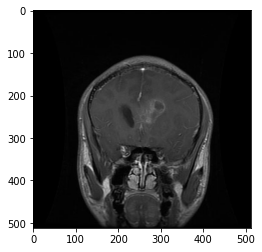

(512, 512, 3)


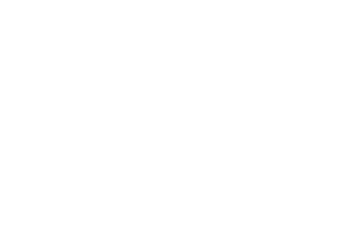

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from skimage import feature
 
DATADIR = r"/content/drive/MyDrive/Dataset/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        print(img_array.shape)
        break
    break

In [ ]:
IMG_SIZE = 150

# PreProcessing

In [ ]:
training_data = []
 
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

Loading Data

In [ ]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
#normalizing
X = X/255.0  
X = X.reshape(-1,150,150,1)

(2870, 150, 150)


Convert to one-hot-encoding

In [ ]:
from keras.utils.np_utils import to_categorical 
y = to_categorical(y, num_classes = 4)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2296, 150, 150, 1)
x_test shape (574, 150, 150, 1)
y_train shape (2296, 4)
y_test shape (574, 4)


# CNN Model

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
 
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
 
model = Sequential()
#
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
#
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
 
#
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
 
# 
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.001,beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 50
batch_size = 40
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=True)

Traininig

In [ ]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
57/57 [==============================] - 257s 4s/step - loss: 1.3995 - accuracy: 0.3148 - val_loss: 1.2991 - val_accuracy: 0.3136
Epoch 2/50
57/57 [==============================] - 256s 4s/step - loss: 1.1374 - accuracy: 0.5002 - val_loss: 1.0421 - val_accuracy: 0.5261
Epoch 3/50
57/57 [==============================] - 256s 4s/step - loss: 0.9861 - accuracy: 0.5896 - val_loss: 0.9520 - val_accuracy: 0.5714
Epoch 4/50
57/57 [==============================] - 258s 5s/step - loss: 0.8985 - accuracy: 0.6162 - val_loss: 0.8127 - val_accuracy: 0.6638
Epoch 5/50
57/57 [==============================] - 258s 5s/step - loss: 0.8476 - accuracy: 0.6445 - val_loss: 0.7744 - val_accuracy: 0.6638
Epoch 6/50
57/57 [==============================] - 259s 5s/step - loss: 0.7998 - accuracy: 0.6472 - val_loss: 0.7547 - val_accuracy: 0.6638
Epoch 7/50
57/57 [==============================] - 259s 5s/step - loss: 0.7266 - accuracy: 0.6934 - val_loss: 0.8727 - val_accuracy: 0.5993
Epoch 8/50
57

In [ ]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save("/content/drive/MyDrive/Dataset/model_only.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 64)      1664      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)      

#Plotting

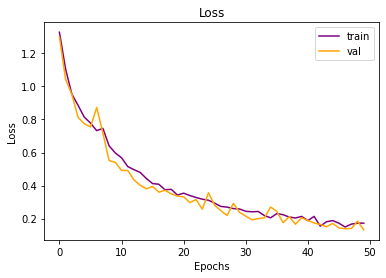

In [ ]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

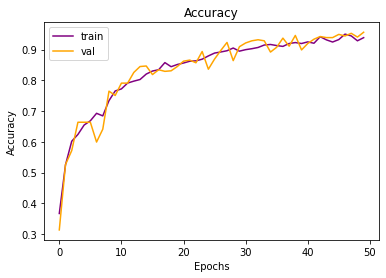

In [ ]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Predicting

Loading Weights

In [ ]:
model.load_weights("/content/drive/MyDrive/Dataset/model.hdf5")

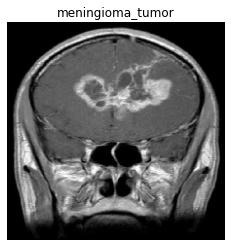

In [ ]:
li=list(['glioma_tumor',
         'meningioma_tumor',
         'no_tumor',
         'pituitary_tumor'])
import tensorflow as tf
from keras.preprocessing import image
from keras_preprocessing import image
images = image.load_img("/content/drive/MyDrive/Dataset/Testing/meningioma_tumor/image(121).jpg", 
                        target_size=(150, 150))    
x = image.img_to_array(images)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0
prediction = model.predict(x)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()